## Procesado de Ficheros I
___

### 1. Imágenes
---
El módulo **imageio** nos permite leer fácilmente imágenes y obtener los _np-arrays_ correspondientes con los datos en bruto

(720, 1280, 3)
[[[ 77  45  22]
  [ 77  45  22]
  [ 78  46  21]
  ...
  [118  78  52]
  [117  77  51]
  [116  76  50]]

 [[ 75  43  20]
  [ 76  44  21]
  [ 77  45  20]
  ...
  [118  78  52]
  [117  77  51]
  [116  76  50]]

 [[ 74  39  17]
  [ 75  40  18]
  [ 77  43  18]
  ...
  [117  80  51]
  [117  78  49]
  [116  77  48]]

 ...

 [[215 165  78]
  [216 166  79]
  [217 167  80]
  ...
  [174 121  51]
  [176 123  53]
  [176 123  53]]

 [[215 165  78]
  [216 166  79]
  [217 167  80]
  ...
  [173 123  54]
  [174 124  55]
  [174 124  55]]

 [[215 165  78]
  [216 166  79]
  [217 167  80]
  ...
  [159 109  40]
  [158 107  41]
  [158 107  41]]]


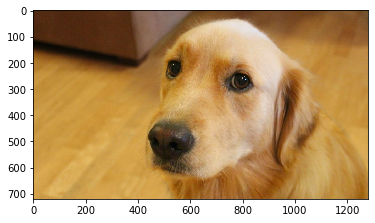

In [19]:
import torch
import numpy as np
import imageio
from matplotlib import pyplot as plt

img_arr = imageio.imread("data/bobby.jpg") # read image as numpy array
print(img_arr.shape) # height x width x channels
print(img_arr)

plt.imshow(img_arr)

#### 1.1 Reordenando las dimensiones
___
El formato de la imagen que acabamos de leer es: H x W x C

Sin embargo, los módulos de PyTorch que trabajan con imágenes requieren que los tensores correspondientes estén en el formato: C x H x W

Podemos cambiar fácilmente el orden de las dimensiones con el método **permute**. Este método no realiza una copia de los datos del tensor, simplemente obtiene un nuevo tensor con valores diferentes de _stride_ y _size_.

In [18]:
img = torch.from_numpy(img_arr)
print("img_shape: ", img.shape)
print("img_stride: ", img.stride())

out = img.permute(2, 0, 1) # C x W x H
print("out_shape: ", out.shape)
print("out_stride: ", out.stride())

img_shape:  torch.Size([720, 1280, 3])
img_stride:  (3840, 3, 1)
out_shape:  torch.Size([3, 720, 1280])
out_stride:  (1, 3840, 3)


Podemos seguir este mismo procedimiento para crear un _dataset_ de múltiples imágenes y usarlo como entrada de una red neuronal. Simplemente añadiremos una nueva dimensión al tensor con el número de imágenes del _batch_: N x C x H x W

Una alternativa ligeramente más eficiente que usar **stack** con el tensor, es crearlo primero con el tamaño requerido y, posteriormente, "cargarlo" con los datos de las imágenes.

En el siguiente ejemplo se crea un _batch_ de 3 imágenes de 256x256 píxels y 3 componentes de color por píxel (1 byte por componente).

In [4]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

En el siguiente ejemplo se cargan todas las imágenes contenidas en la carpeta indicada

['cat1.png', 'cat2.png', 'cat3.png']


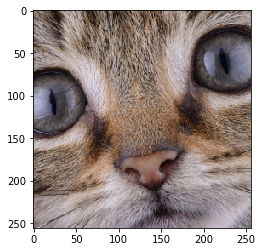

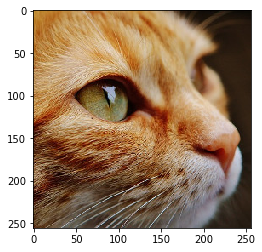

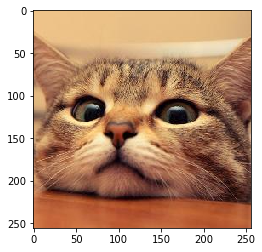

In [5]:
import os

# files
data_dir = "data/image-cats/"
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']
print(filenames)

for i, filename in enumerate(filenames):
    # load image
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    
    # display image
    plt.figure(i)
    plt.imshow(img_arr)    

    # add image to the batch
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3] # drop alpha channel if exists
    batch[i] = img_t


#### 1.2 Normalizando los datos
___
Las redes neuronales muestran su mejor comportamiento cuando los rangos de los datos de entrada se encuentran en los intervalos \[0,1\] ó \[-1,\1].

Una posibilidad consiste en dividir los valores de los píxeles por 255 (valor máximo de un entero de 8 bits sin signo).

In [7]:
batch = batch.float()
batch /= 255.0

Otra posibilidad consiste en calcular la media y la desviación estándar de los datos de entrada y escalarlos de forma que la media sea 0 y la desviación estándar 1 por **canal**:

In [9]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean)/std

En el ejemplo precedente hemos normalizado cada componente de color a partir de la media y la desviación estándar de la correspondiente componente de color de todas las imágenes del batch. 

En general, es una buena práctica calcular dichos valores (media y desviación) sobre **todas las imágenes del _dataset_ de pruebas** y, posteriormente, normalizar todas las imágenes del _dataset_ antes del entrenamiento.



#### 1.3 Imágenes volumétricas
___
En determinadas situaciones, como el procesado de escáneres tomográficos, tenderemos que lidiar con imágenes volumétricas. Por ejemplo, en este caso, obtendremos imágenes en escala de grises donde el brillo del píxel representa una medida de la densidad de la parte del cuerpo escaneada (más densidad -> blanco).

<br>

![](data/image-lect/ct_scan.png)

<br>

Dado que sólo tenemos una canal de color, los formatos nativos suelen "deshacerse" de dicho canal. Adicionalmente, tendremos un nuevo canal, _depth_, que servirá para indexar la profundidad (en un eje longitudinal cabeza-pies) cada una de las imágenes.

Para el procesado de dichas imágenes, nos conviene expresarlas como un tensor con la siguiente estructura: _N x C x D x H x W_

A modo de ejemplo, vamos a importar un conjunto de estas imágenes usando la función _volread_ de _imageio_. Originalmente, su formato será _D x H x W_, de forma que tendremos que añadir una nueva dimensión (_unsqeeze_) para el canal (aunque sea 1).

Reading DICOM (examining files): 1/4 files (25.0%4/4 files (100.0%)
  Found 2 correct series.
Reading DICOM (loading data): 3/3  (100.0%)
(3, 512, 512)
torch.Size([1, 3, 512, 512]) [C x D x H x W]


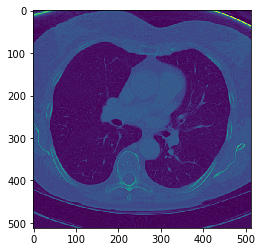

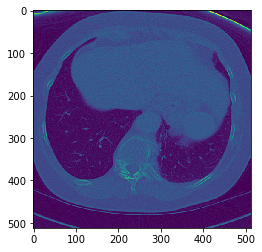

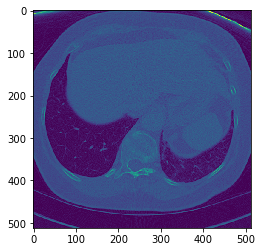

In [17]:
dir_path = "data/image-dicom/"

vol_arr = imageio.volread(dir_path, 'DICOM')
print(vol_arr.shape)

for i, img in enumerate(vol_arr):
    plt.figure(i)
    plt.imshow(img)
    
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)

print(vol.shape, "[C x D x H x W]")